First import the libraries needed in this notebook.

In [167]:
import numpy as np
import pandas as pd

#import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, LinearLocator, FixedLocator
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical

from random import randrange

The MNIST data can easily be obtained with the `tensorflow_datasets` library. In the cell below, if `download_data = True`, then tensorflow will download the MNIST data and store it in the directory `./data`. Otherwise, it will look for the data in the `./data` directory. 

The cell below loads the MNIST data into the variables `data` and `info`.

In [6]:
download_data = False

if download_data:
    
    data, info = tfds.load('mnist', with_info=True, data_dir='./data')

else:
        
    data, info = tfds.load('mnist', with_info=True, download=False, data_dir='./data')

Extract the training data and test data.

In [20]:
train_data = tfds.as_numpy(data['train'])
test_data = tfds.as_numpy(data['test'])

The digit images and labels are somewhat hidden in train_data and test_data. In order to obtain the data to work with, the function `extract_data` is defined below. The function:
* appends each digit image to an array X
* appends each digit label to the array y
* normalises each digit image by dividing by 255
* one-hot encodes the digit labels y. This means that if the digit was 1 then it is turned into the array [0, 1, {8 more zeros}]

In [18]:
def extract_data(generator):
    '''This functgion returns two numpy arrays X and y. Each element of X contains a 
       normalised 28x28 numpy array of a digit. The corresponding element in y is the 
       one-hot encoded digit label.'''
    
    X = []
    y = []

    for digit in generator:
    
        X.append(digit['image'])
        y.append(digit['label'])       

    X = np.array(X)/255
    y = np.array(y)

    y = to_categorical(y)
    
    return X, y

In [21]:
# NB: Since train_data and test_data are generators, this cell can only be run once.
# If this cell needs to be rerun, then the cell defining the generators train_data and
# test_data needs to be rerun again first. 
X, y = extract_data(train_data)
X_test, y_test = extract_data(test_data)

Of the digits in the training data, 15% of them will be declared as a validation set in order to probe the accuracy of the models that will be built.

In [10]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=0)

In order to check that the data has been loaded correctly, a sample element of the training data can be displayed.

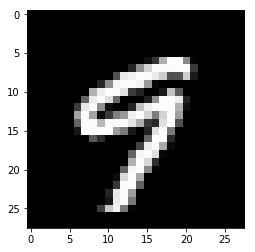

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [11]:
i = 10
plt.gray()
plt.imshow(X_train[i].reshape(28,28), interpolation='none')
plt.show()

print(y_train[i])


Now that the digit images and labels have been specified, it is possible to begin constructing the neural networks that can model this data.

## The First Model

The first model that will be built will have:
* An initial *flat* layer of 784 neurons corresponding to each of the pixels in the 28x28 image.
* 5 hidden layers of 30 fully connected neurons each. These neurons will have a ReLU activation.
* A final layer of 10 neurons corresponding to the 10 digits. The neurons in this final layer will have a softmax activation. 

The model can be easily constucted using Keras as shown below. 

In [35]:
model = Sequential()

model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='softmax'))

A summary of the model can be made.

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                310       
Total para

The model will have:
* The adam optimizer
* Categorical cross entropy as a loss function to guide training
* Accuracy as a metric

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model will be trained for 20 epochs. Each epoch represents a single pass through the training data. 

In [38]:
first_model_output = model.fit(X_train, y_train, epochs=20, validation_data=(X_validate, y_validate))
first_model = model

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 5s 91us/step - loss: 0.4304 - acc: 0.8693 - val_loss: 0.2234 - val_acc: 0.9328
Epoch 2/20
51000/51000 [==============================] - 4s 79us/step - loss: 0.1967 - acc: 0.9405 - val_loss: 0.1975 - val_acc: 0.9416
Epoch 3/20
51000/51000 [==============================] - 4s 79us/step - loss: 0.1552 - acc: 0.9529 - val_loss: 0.1547 - val_acc: 0.9542
Epoch 4/20
51000/51000 [==============================] - 4s 80us/step - loss: 0.1276 - acc: 0.9611 - val_loss: 0.1483 - val_acc: 0.9581
Epoch 5/20
51000/51000 [==============================] - 4s 81us/step - loss: 0.1124 - acc: 0.9654 - val_loss: 0.1352 - val_acc: 0.9614
Epoch 6/20
51000/51000 [==============================] - 5s 88us/step - loss: 0.1013 - acc: 0.9693 - val_loss: 0.1467 - val_acc: 0.9587
Epoch 7/20
51000/51000 [==============================] - 4s 73us/step - loss: 0.0909 - acc: 0.9721 - val_loss: 0.1381 - val_acc:

For epoch, both the loss and accuracy for the training data and validation data can be extracted into a Pandas dataframe.

In [39]:
metrics = pd.DataFrame(first_model_output.history)

# The index of the metrics dataframe is zero indexed to the epoch number. As such, add one
# to the index so that Epoch 0 becomes Epoch 1.
metrics.index = metrics.index+1

This information can be plotted.

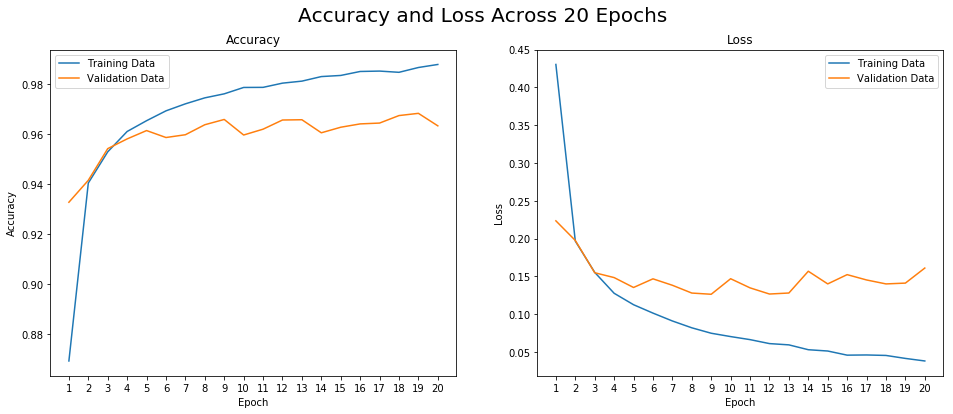

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=metrics, ax=ax[0], x = metrics.index, y='acc', label='Training Data')
sns.lineplot(data=metrics, ax=ax[0], x = metrics.index, y='val_acc', label='Validation Data')

sns.lineplot(data=metrics, ax=ax[1], x = metrics.index, y='loss', label='Training Data')
sns.lineplot(data=metrics, ax=ax[1], x = metrics.index, y='val_loss', label='Validation Data')

fig.suptitle('Accuracy and Loss Across 20 Epochs', fontsize=20)

ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend()

ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend()


As can be seen in the plot on the top left, the accuracy of the training data quickly increases in the first three epochs, followed by a gradual, but non-stop climb towards 100%. This is despite the accuracy on the validation data plateauing  at around 96% after approximately the 6th epoch. This shows that after approximately 6 epochs, the model is  overfitted. 

Something similar happens to the loss. As can be seen in the plot on the top right, the loss for the training data approaches zero as the epochs increase. However, the loss for the validation data plateaus at around 0.15 after approximately 6 epochs. This is further evidence that the model is overfitting after 6 epochs.

An estimate of the accuracy of the model can be made by taking the mean and standard deviation of the accuracy on the validation data for the epochs 6 through to 20. 

In [98]:
mean = metrics['val_acc'][5:20].mean()
std = metrics['val_acc'][5:20].std()

print('Accuracy on validation data after overfitting is {:.3f} \u00B1 {:.3f}'.format(mean, std))

Accuracy on validation data after overfitting is 0.963 ± 0.003


To determine the accuracy of the model on the test data, predictions can be made.

In [106]:
predictions = first_model.predict(X_test)

The digit that will be predicted is simply the argument of the array that is the maximum.

In [107]:
predictions = [np.argmax(x) for x in predictions]

Create the list `y_test_digits` that reverses the one-hot coding.

In [111]:
y_test_digits = [np.argmax(x) for x in y_test]

Use the `accuracy_score` function from `sklearn.metrics` to determine the accuracy.

In [110]:
accuracy_score(predictions, y_test_digits)

0.9667

More simply, Keras allows the direct evaluation of the model with the following simple command. However, this command obscures the actual predictions of the model. The first number in the array below is the loss and the second element is the accuracy, which is the same as determined before.

In [112]:
first_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 37us/step


[0.14456992904888466, 0.9667]

In an effort to show what learning the model has made, a display of digits versus their predicted labels is shown below for a random selection of the test data.

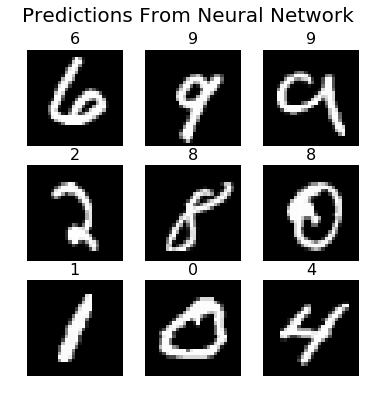

In [170]:
# Obtain a random selection of 9 digit images 
random_indices = [randrange(X_test.shape[0]) for x in range(9)]
random_indices_copy = random_indices # A copy has been made because pop will be used later
X_images = X_test[random_indices]

# Determine the predictions of these 9 images
predictions = first_model.predict(X_images)
predictions = [np.argmax(x) for x in predictions]

# Create the figure
fig, ax = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle('Predictions From Neural Network', fontsize=20)

for i in [0,1,2]:           # loop across the three rows
    for j in [0,1,2]:       # loop across the three columns
        
        # Obtain the first or next random index
        random_index = random_indices_copy.pop(0)
        
        # Obtain the prediction for this digit
        prediction = predictions.pop(0)
        
        # Plot the digit and show the prediction
        ax[i,j].imshow(X_test[random_index].reshape(28,28), interpolation='none')
        ax[i,j].set_axis_off()
        ax[i,j].set_title(prediction, fontsize=16)
    

## CNN Model

In [93]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(60, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

W0716 11:03:35.981369 140593074353920 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 40)        7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 60)          9660      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 60)          0         
__________

In [95]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
output = model.fit(X_train, y_train, epochs=20,  validation_data=(X_validate, y_validate))
second_model = model

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 44s 863us/step - loss: 0.2936 - acc: 0.9079 - val_loss: 0.0722 - val_acc: 0.9783
Epoch 2/20
51000/51000 [==============================] - 43s 837us/step - loss: 0.0988 - acc: 0.9699 - val_loss: 0.0452 - val_acc: 0.9850
Epoch 3/20
51000/51000 [==============================] - 43s 835us/step - loss: 0.0735 - acc: 0.9774 - val_loss: 0.0502 - val_acc: 0.9846
Epoch 4/20
51000/51000 [==============================] - 43s 841us/step - loss: 0.0621 - acc: 0.9809 - val_loss: 0.0355 - val_acc: 0.9892
Epoch 5/20
51000/51000 [==============================] - 43s 844us/step - loss: 0.0522 - acc: 0.9836 - val_loss: 0.0311 - val_acc: 0.9900
Epoch 6/20
51000/51000 [==============================] - 43s 847us/step - loss: 0.0490 - acc: 0.9846 - val_loss: 0.0369 - val_acc: 0.9872
Epoch 7/20
51000/51000 [==============================] - 45s 879us/step - loss: 0.0448 - acc: 0.9860 - val_loss: 0.0

In [103]:
predictions = second_model.predict(X_test)

In [104]:
predictions = [np.argmax(x) for x in predictions]

In [102]:
accuracy_score(predictions, y_test)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [24]:
second_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 327us/step


[0.023139943968826265, 0.9944]